Training from several snapshots of data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append(((p[:,i-1,:,:] - p[:,i,:,:])*np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [3]:
sla_summer, uif_summer = in_out('af_summer', 'wf_summer')  #first snapshot of data (0002-00172), summer

In [4]:
sla_summer[0]

array([ 3.2483165e+08,  4.1973315e+08,  4.1957971e+08,  4.1792554e+08,
        4.1608573e+08,  4.1529331e+08,  4.1917523e+08,  4.2553757e+08,
        4.2796963e+08,  4.2935677e+08,  4.3002480e+08,  4.3050189e+08,
        4.2917203e+08,  4.2745120e+08,  4.2514688e+08,  4.2291594e+08,
        4.1778349e+08,  4.1280435e+08,  4.0147472e+08,  3.9112733e+08,
        3.8413638e+08,  3.7656957e+08,  3.6903552e+08,  3.6089472e+08,
        3.4957466e+08,  3.3627162e+08,  3.2291926e+08,  3.1016934e+08,
        2.9839315e+08,  2.8756467e+08,  2.7648986e+08,  2.6690755e+08,
        2.5770624e+08,  2.4404589e+08,  2.3087686e+08,  2.2010757e+08,
        2.1086104e+08,  2.0501749e+08,  2.0513592e+08,  1.9989923e+08,
        1.9729146e+08,  2.0554002e+08,  2.1805370e+08,  2.2201814e+08,
        2.1955205e+08,  2.1646682e+08,  2.2063669e+08,  2.3553512e+08,
        2.5117816e+08,  2.5322378e+08,  2.4153790e+08,  2.2494416e+08,
        1.9879157e+08, -0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      

In [5]:
sla_fall, uif_fall = in_out('af_fall', 'wf_fall') #(0002-00352), fall

In [6]:
sla_winter, uif_winter = in_out('af_winter', 'wf_winter') #(0002-00352), winter 

In [7]:
sla_spring, uif_spring = in_out('af_spring', 'wf_spring') #(0002-00652), spring 

In [8]:
sla_test, uif_test = in_out("af_test", "wf_test") #(0002-00472), testing on this as well to check if overfit

In [9]:
uif_train = np.concatenate((uif_summer, uif_fall, uif_winter, uif_spring), axis=0) #total uif for training

In [10]:
sla_train = np.concatenate((sla_summer, sla_fall, sla_winter, sla_spring), axis=0) #total sla for training

In [11]:
from sklearn.model_selection import train_test_split
sla_train, sla_test, uif_train, uif_test = train_test_split(sla_train, uif_train, test_size=0.9, random_state=42)

In [12]:
uif_train.shape

(227059, 52)

# Predicting Summer:

In [13]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(sla_train,uif_train)
uif_lin = lr1.predict(sla_summer)  
uif_out = uif_summer

In [15]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.8708057

In [16]:
np.min(uif_out)

17.541994

In [17]:
np.max(uif_out)

339.41235

In [18]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

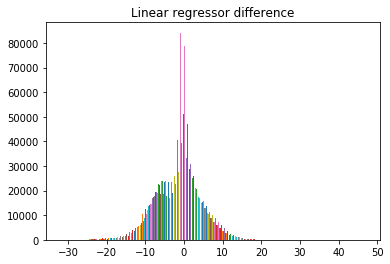

In [19]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [20]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [21]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

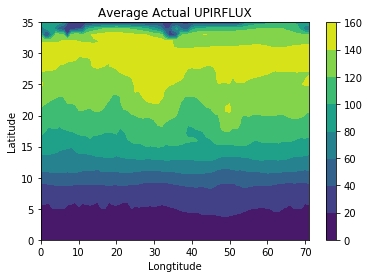

In [22]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

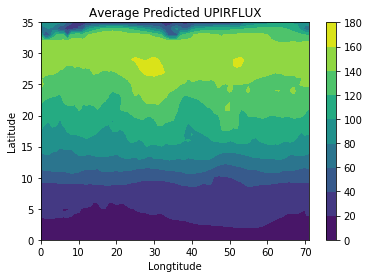

In [23]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

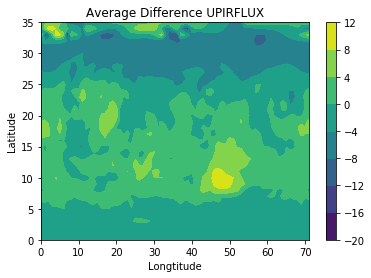

In [24]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

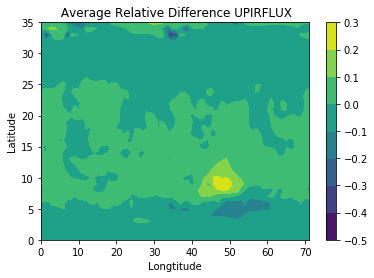

In [25]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [26]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

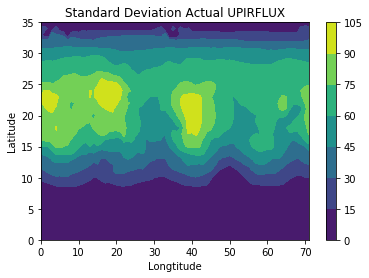

In [27]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

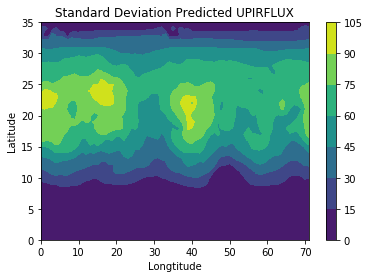

In [28]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

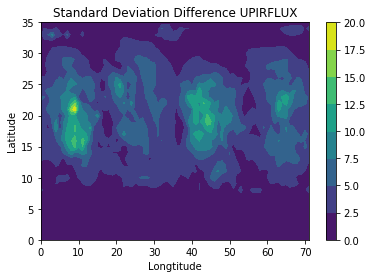

In [29]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [32]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [33]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [34]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.08033474, -0.00941697, -0.27146449, ..., -0.73542462,
        -0.17824783, -0.20979559],
       [ 0.08044848, -0.0092933 , -0.27133652, ..., -0.73530455,
        -0.17812055, -0.2096684 ],
       [ 0.08047433, -0.00926852, -0.27131166, ..., -0.73528146,
        -0.17809672, -0.2096459 ],
       ...,
       [-0.01181406, -0.64507506, -0.416322  , ..., -0.88434645,
        -0.30533497, -0.88537584],
       [-0.00453589, -0.67050643, -0.4279427 , ..., -0.88720029,
        -0.29593455, -0.90903   ],
       [ 0.00296604, -0.70524093, -0.4461898 , ..., -0.88943772,
        -0.28620714, -0.94128947]])

In [35]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.12572817, 0.12584698, 0.12587408, 0.12589226, 0.12589231,
       0.1258107 , 0.12539486, 0.12542753, 0.12535478, 0.12530953,
       0.12536317, 0.12547224, 0.12542667, 0.12547067, 0.12527316,
       0.12497456, 0.12368051, 0.12102399, 0.11676076, 0.11036271,
       0.10084809, 0.08740279, 0.0715687 , 0.05849436, 0.04869454,
       0.04297777, 0.03893846, 0.03879004, 0.03959517, 0.03940721,
       0.03639767, 0.0338786 , 0.0276645 , 0.01808947, 0.01398321,
       0.01951611, 0.032011  , 0.04172098, 0.05029617, 0.05317256,
       0.0544723 , 0.0532279 , 0.04952077, 0.04642118, 0.04323029,
       0.04031568, 0.03784427, 0.03792154, 0.03740995, 0.04030156,
       0.04763408, 0.05407654])

In [36]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.73701817, -0.73689714, -0.7368701 , -0.73690672, -0.7369871 ,
       -0.73685782, -0.73702644, -0.73702966, -0.73727171, -0.73745114,
       -0.73735997, -0.73710583, -0.73715223, -0.73727236, -0.73763512,
       -0.73784596, -0.73864333, -0.740597  , -0.74458161, -0.75111484,
       -0.76039812, -0.772773  , -0.78653148, -0.79762883, -0.80650539,
       -0.81207888, -0.81645024, -0.8177525 , -0.81946881, -0.82274633,
       -0.82938783, -0.83704403, -0.84913641, -0.85908242, -0.85874482,
       -0.85323728, -0.8480409 , -0.85078943, -0.85389853, -0.85542259,
       -0.87001575, -0.88575051, -0.90278165, -0.91863596, -0.93570723,
       -0.94928353, -0.96352945, -0.97726297, -0.99618552, -1.01793569,
       -1.04315807, -1.07635086])

In [37]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.23743796, 0.23743744, 0.2374379 , 0.23745362, 0.23747898,
       0.23739214, 0.23733914, 0.23736821, 0.23739439, 0.23739309,
       0.23736374, 0.23731818, 0.23731385, 0.23735053, 0.23736122,
       0.23724706, 0.23700514, 0.23673679, 0.23659692, 0.23656516,
       0.2364444 , 0.23590728, 0.23463837, 0.23303572, 0.23160563,
       0.23032775, 0.22898994, 0.22754719, 0.2261124 , 0.22450445,
       0.22287902, 0.2217608 , 0.22093253, 0.21873476, 0.21605913,
       0.21584882, 0.21914723, 0.22618541, 0.23473052, 0.2388886 ,
       0.2434238 , 0.24613143, 0.24876514, 0.25122432, 0.2536732 ,
       0.25556025, 0.25784345, 0.260776  , 0.26508216, 0.27145801,
       0.28051461, 0.2918286 ])

In [38]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.325806  , -0.32568216, -0.32565855, -0.32566728, -0.32571083,
       -0.32571358, -0.32595106, -0.32588677, -0.32602347, -0.32613997,
       -0.32609173, -0.32594827, -0.32600248, -0.32604906, -0.32632559,
       -0.32656396, -0.32761263, -0.3299195 , -0.33405993, -0.34044658,
       -0.34957745, -0.36227583, -0.37739835, -0.39074912, -0.40229546,
       -0.4102838 , -0.41668354, -0.41997989, -0.42338574, -0.42786488,
       -0.43531815, -0.44424116, -0.45900388, -0.47515876, -0.48519733,
       -0.49031869, -0.49423153, -0.50579172, -0.51901989, -0.52553314,
       -0.533602  , -0.53987677, -0.54776421, -0.55467853, -0.56247668,
       -0.56919825, -0.57572259, -0.58034689, -0.58812476, -0.59631075,
       -0.60409462, -0.61549566])

In [39]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.42748575776975906


# Predicting Fall:

In [40]:
uif_lin = lr1.predict(sla_fall) 
uif_out = uif_fall

In [42]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.067406

In [43]:
np.min(uif_out)

15.713927

In [44]:
np.max(uif_out)

484.24545

In [45]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

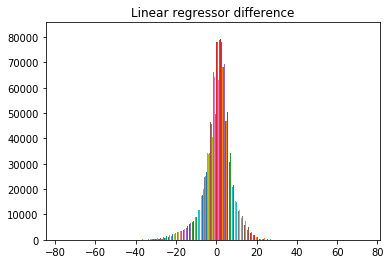

In [46]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [47]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [48]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

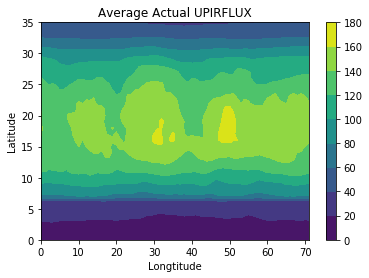

In [49]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

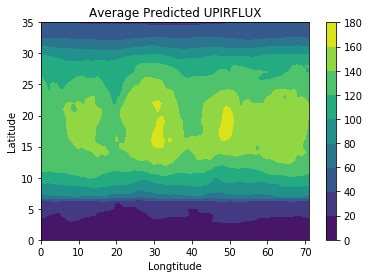

In [50]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

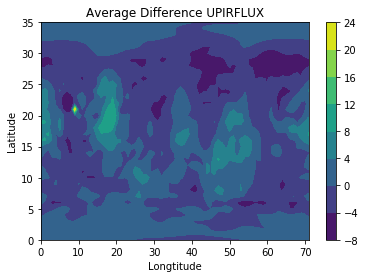

In [51]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

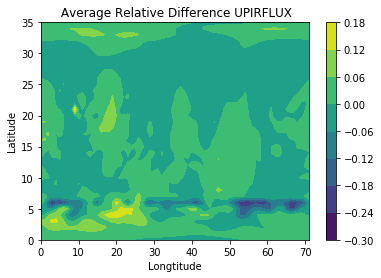

In [52]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [53]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

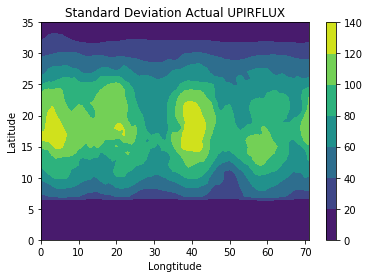

In [54]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

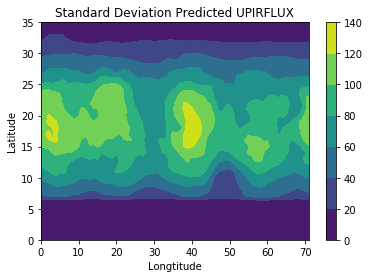

In [55]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

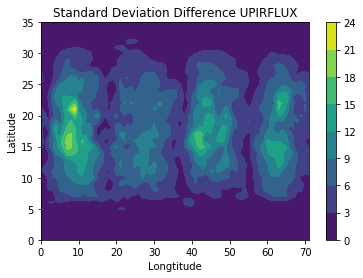

In [56]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [57]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [58]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [59]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-1.15728366e-01, -4.05776377e-01, -2.48956594e-01, ...,
        -5.93667862e-01,  1.82284861e-01,  1.54065859e-01],
       [-1.15479613e-01, -4.05523335e-01, -2.48691305e-01, ...,
        -5.93415874e-01,  1.82544350e-01,  1.54332819e-01],
       [-1.15457958e-01, -4.05500301e-01, -2.48672653e-01, ...,
        -5.93396675e-01,  1.82568204e-01,  1.54363954e-01],
       ...,
       [-5.46728118e-01, -1.36746710e+00, -7.20187324e-01, ...,
        -1.02163640e+00, -5.85665224e-02, -6.19081221e-01],
       [-5.20230545e-01, -1.38056278e+00, -7.12179190e-01, ...,
        -1.00272571e+00, -3.26703732e-02, -6.32584453e-01],
       [-4.83565371e-01, -1.39549981e+00, -7.02661860e-01, ...,
        -9.75710631e-01,  6.53700703e-04, -6.50353557e-01]])

In [60]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.22358726,  0.22383604,  0.22385891,  0.22385828,  0.22367408,
        0.22373435,  0.22375813,  0.22393611,  0.22390875,  0.22367349,
        0.22349972,  0.22348875,  0.2234272 ,  0.22287897,  0.22184039,
        0.22072812,  0.21936681,  0.21812785,  0.21705393,  0.21719513,
        0.21861038,  0.22088249,  0.22239412,  0.22220244,  0.21711227,
        0.20812667,  0.19467193,  0.17808754,  0.15529787,  0.12796251,
        0.09768812,  0.06670369,  0.02775852, -0.01916795, -0.06306088,
       -0.10147627, -0.12726085, -0.13900433, -0.13505285, -0.13043675,
       -0.12457411, -0.12146181, -0.11943867, -0.11438079, -0.10672837,
       -0.10115528, -0.09346342, -0.08120041, -0.06743402, -0.04727665,
       -0.01667831,  0.02264458])

In [61]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-1.04865583, -1.04841545, -1.04839543, -1.04847255, -1.04863047,
       -1.04877665, -1.04907037, -1.04891883, -1.04869839, -1.04860498,
       -1.04867128, -1.04880265, -1.04908366, -1.04957475, -1.05028733,
       -1.05098286, -1.05227598, -1.0538913 , -1.05579612, -1.05700936,
       -1.05691578, -1.0555593 , -1.05472926, -1.05592236, -1.06229836,
       -1.07331925, -1.08955845, -1.10985318, -1.13690085, -1.17133225,
       -1.21115863, -1.25304449, -1.30047371, -1.35209911, -1.39709052,
       -1.44396592, -1.49375423, -1.5393596 , -1.56838664, -1.57569775,
       -1.58128793, -1.58468184, -1.58899093, -1.59115023, -1.59233426,
       -1.59341745, -1.5927039 , -1.58738173, -1.58167876, -1.5725671 ,
       -1.5564533 , -1.53061543])

In [62]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.3387338 , 0.33874123, 0.33874304, 0.33879822, 0.33882968,
       0.33888079, 0.33895649, 0.33894789, 0.33881564, 0.33865955,
       0.33862523, 0.33867658, 0.33874424, 0.33873802, 0.33868659,
       0.33862324, 0.33861901, 0.33871538, 0.33895644, 0.33939691,
       0.33989575, 0.34038556, 0.34095934, 0.34169447, 0.34234025,
       0.34303659, 0.34386022, 0.34476435, 0.34575146, 0.34771212,
       0.35041025, 0.35298343, 0.35480657, 0.35632281, 0.35664154,
       0.35794495, 0.36331166, 0.37280885, 0.3833261 , 0.38750915,
       0.39166358, 0.39409573, 0.39663198, 0.39934129, 0.40231698,
       0.40459473, 0.40715233, 0.41004093, 0.41352172, 0.41773752,
       0.42264081, 0.4285544 ])

In [63]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.19331656, -0.19305993, -0.19303746, -0.19304283, -0.19315829,
       -0.19316958, -0.19332249, -0.19326439, -0.19337761, -0.19358065,
       -0.19366152, -0.19370217, -0.19393458, -0.19449853, -0.19533077,
       -0.19606507, -0.19715927, -0.19826936, -0.19934591, -0.19946729,
       -0.19843647, -0.19639722, -0.19485554, -0.19506811, -0.20080628,
       -0.21127563, -0.22697118, -0.246759  , -0.27330838, -0.30544428,
       -0.34225278, -0.38162392, -0.42821659, -0.48054833, -0.53027587,
       -0.58316158, -0.63537242, -0.68064063, -0.70740912, -0.71446801,
       -0.71989062, -0.72307325, -0.72697176, -0.72828907, -0.72843065,
       -0.72915806, -0.72884622, -0.72522298, -0.72239088, -0.71650461,
       -0.70567517, -0.69106644])

In [64]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.3898572169162386


# Predicting Winter:

In [65]:
uif_lin = lr1.predict(sla_winter)  
uif_out = uif_winter

In [67]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

8.502684

In [68]:
np.min(uif_out)

15.832658

In [69]:
np.max(uif_out)

485.98044

In [70]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

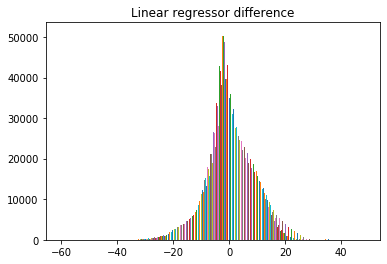

In [71]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [72]:
uif_out.reshape(-1,1).shape

(32213376, 1)

## Average Error Plots

In [73]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

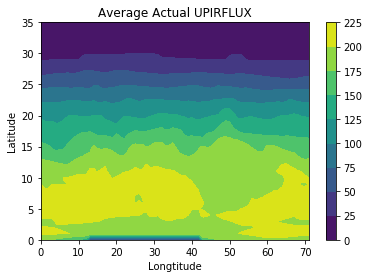

In [74]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

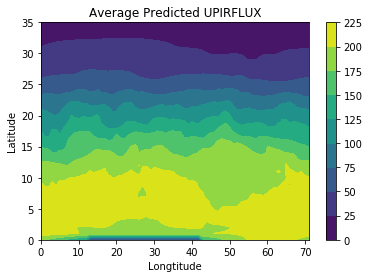

In [75]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

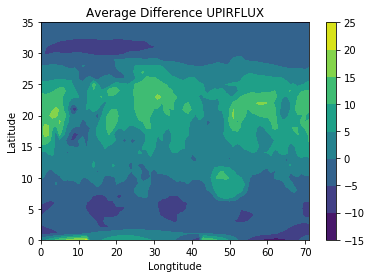

In [76]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

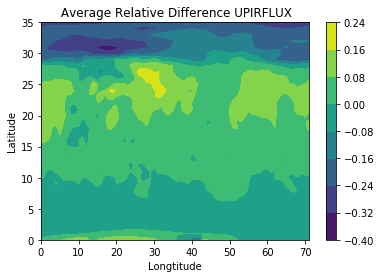

In [77]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [78]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

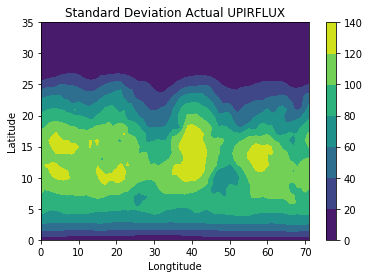

In [79]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

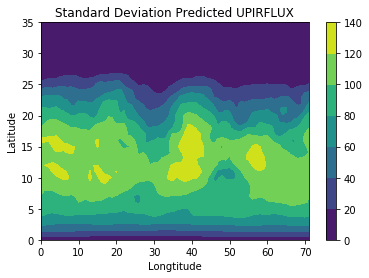

In [80]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

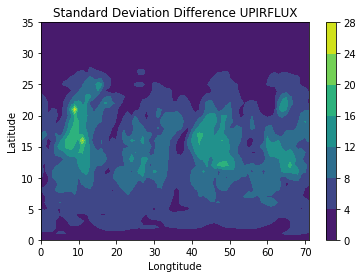

In [81]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [82]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [83]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [84]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[3.45779117, 3.04004362, 3.31352802, ..., 2.27277145, 2.70188185,
        2.56099455],
       [3.45802062, 3.04027045, 3.31376716, ..., 2.27301336, 2.70212562,
        2.56122137],
       [3.45809387, 3.0403377 , 3.31383253, ..., 2.27305457, 2.70217133,
        2.56125297],
       ...,
       [6.13339262, 4.83862965, 5.45898889, ..., 3.62113283, 4.40196359,
        3.43341913],
       [6.14311566, 4.81411865, 5.44321491, ..., 3.62559205, 4.41864681,
        3.41708816],
       [6.15071692, 4.76478355, 5.41139971, ..., 3.62848858, 4.43719311,
        3.38304366]])

In [85]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([3.45779117, 3.45802062, 3.45809387, 3.45805025, 3.45783222,
       3.45762173, 3.45755844, 3.45777196, 3.45782901, 3.45711574,
       3.45633919, 3.45614779, 3.45663222, 3.45676484, 3.45864641,
       3.46224739, 3.46701621, 3.47377445, 3.48211065, 3.49367022,
       3.50991997, 3.53229831, 3.56176214, 3.6027402 , 3.65389385,
       3.71742988, 3.79055889, 3.87852304, 3.98050889, 4.10111999,
       4.24648593, 4.41644242, 4.59688   , 4.78970815, 4.99104076,
       5.19909056, 5.41279296, 5.62676994, 5.79468299, 5.85558153,
       5.9156226 , 5.95129387, 5.98663441, 6.02314877, 6.05745384,
       6.07731593, 6.09521729, 6.11141931, 6.12276751, 6.13339262,
       6.14311566, 6.15071692])

In [86]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([2.25437301, 2.25460556, 2.25465382, 2.25451968, 2.25414979,
       2.25384181, 2.25339576, 2.25316586, 2.25340671, 2.25328461,
       2.25315096, 2.25335133, 2.25386019, 2.2546699 , 2.25612264,
       2.25932403, 2.26381275, 2.27014309, 2.27806798, 2.28880908,
       2.30272314, 2.31908183, 2.33852943, 2.36527887, 2.39717272,
       2.43590473, 2.47093564, 2.51702492, 2.57285273, 2.63769006,
       2.71299523, 2.8042079 , 2.89912011, 2.99519741, 3.09419819,
       3.19917312, 3.31117153, 3.41009777, 3.43866577, 3.44572312,
       3.45020871, 3.4514763 , 3.4509211 , 3.45166164, 3.45257921,
       3.45132404, 3.44983578, 3.44927735, 3.4433632 , 3.43341913,
       3.41708816, 3.38304366])

In [87]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.30771662, 0.30771896, 0.30772434, 0.30773205, 0.30778862,
       0.30782879, 0.30788723, 0.30793864, 0.30792346, 0.3078357 ,
       0.30773084, 0.30761354, 0.30754266, 0.3075722 , 0.30768267,
       0.30783284, 0.30804876, 0.30831574, 0.30847757, 0.30862905,
       0.30901477, 0.30997537, 0.31183749, 0.3148361 , 0.31899169,
       0.32443378, 0.33052141, 0.33718722, 0.34502165, 0.35503984,
       0.36781602, 0.38222708, 0.39845362, 0.41831589, 0.44015455,
       0.46271994, 0.48756291, 0.51646515, 0.54079463, 0.55068694,
       0.56141438, 0.56820686, 0.57534856, 0.58240758, 0.58890393,
       0.59294477, 0.59655786, 0.59972723, 0.60343855, 0.6080017 ,
       0.61340154, 0.62210958])

In [88]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([2.85456083, 2.85479457, 2.85484422, 2.85466409, 2.85441319,
       2.85411396, 2.85391779, 2.85394608, 2.85406454, 2.8537591 ,
       2.85343159, 2.85325364, 2.85334069, 2.85388759, 2.85525118,
       2.85834375, 2.86257678, 2.86854718, 2.87601594, 2.88632945,
       2.90054797, 2.91976447, 2.94403057, 2.97615387, 3.01384937,
       3.05949821, 3.11246972, 3.17797772, 3.25459646, 3.34362747,
       3.44809271, 3.57030537, 3.69960052, 3.83486372, 3.97197207,
       4.11044249, 4.24912698, 4.37867156, 4.47347788, 4.50510406,
       4.53367405, 4.54890481, 4.56230647, 4.57607843, 4.58817555,
       4.59390769, 4.59914407, 4.60517614, 4.60701748, 4.60636971,
       4.60219988, 4.58855357])

In [89]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
3.52153340742661


# Predicting Spring:

In [90]:
uif_lin = lr1.predict(sla_spring)
uif_out = uif_spring

In [92]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

6.2189264

In [93]:
np.min(uif_out)

15.936197

In [94]:
np.max(uif_out)

414.86307

In [95]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

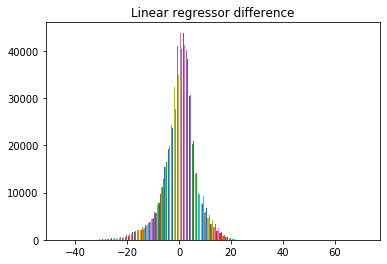

In [96]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [97]:
uif_out.reshape(-1,1).shape

(21430656, 1)

## Average Error Plots

In [98]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

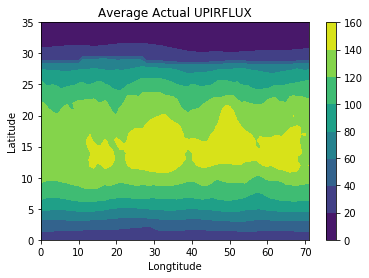

In [99]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

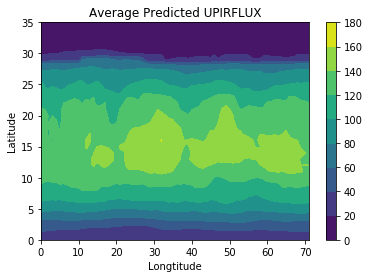

In [100]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

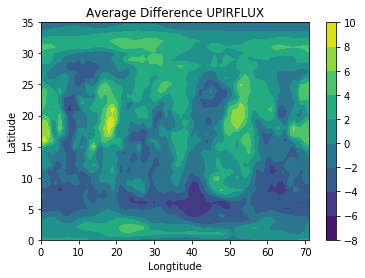

In [101]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

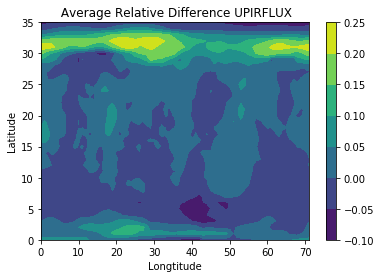

In [102]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [103]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

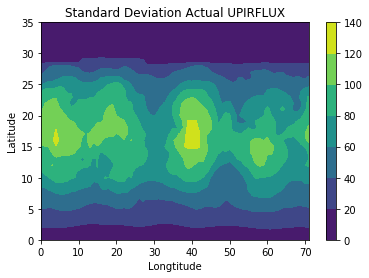

In [104]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

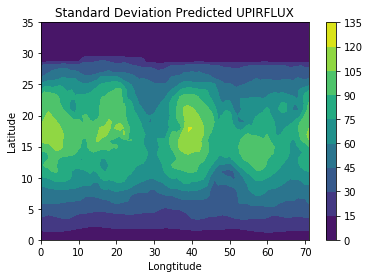

In [105]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

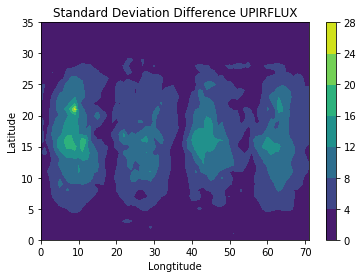

In [106]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [107]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [108]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [109]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.1899915 ,  0.02158855,  0.36709998, ..., -0.06956767,
         0.35509622,  0.25510953],
       [ 0.19020347,  0.02181068,  0.36733032, ..., -0.06937475,
         0.3552919 ,  0.25530756],
       [ 0.19023249,  0.02184255,  0.36735427, ..., -0.06934649,
         0.35532274,  0.25534061],
       ...,
       [-0.03020664, -0.70374579,  0.17747366, ..., -0.33895817,
         0.24408252, -0.3283936 ],
       [ 0.00217343, -0.70597635,  0.19626486, ..., -0.31921799,
         0.2729622 , -0.32801642],
       [ 0.04590028, -0.71004307,  0.22173124, ..., -0.2854455 ,
         0.31648088, -0.3269036 ]])

In [110]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.71839704, 0.71860042, 0.7186294 , 0.71864747, 0.71849933,
       0.71857772, 0.71859318, 0.71884838, 0.71880268, 0.71859515,
       0.71849927, 0.71860366, 0.71844102, 0.71795654, 0.717094  ,
       0.71607563, 0.71393989, 0.7107334 , 0.70684629, 0.70363276,
       0.70250974, 0.70377197, 0.705366  , 0.70591304, 0.70158227,
       0.69301178, 0.67894993, 0.66417537, 0.64663026, 0.62419621,
       0.5969802 , 0.57496224, 0.55437211, 0.53797488, 0.52825593,
       0.51237413, 0.49202386, 0.47727642, 0.48132925, 0.48757591,
       0.49630353, 0.50288368, 0.50987404, 0.51988719, 0.53159743,
       0.53954879, 0.54891804, 0.56559667, 0.58657094, 0.61480372,
       0.65364887, 0.70570795])

In [111]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.11216203, -0.1119575 , -0.11192595, -0.11191564, -0.11191438,
       -0.1119119 , -0.11232677, -0.11248755, -0.11240036, -0.11230769,
       -0.11234792, -0.11253527, -0.11284218, -0.11322149, -0.11382297,
       -0.11456415, -0.11631641, -0.11899932, -0.12241979, -0.12525283,
       -0.12604252, -0.12471326, -0.12375845, -0.12458862, -0.13036356,
       -0.14068286, -0.15679837, -0.1734091 , -0.19246976, -0.21604155,
       -0.2458098 , -0.27430397, -0.30352413, -0.3322764 , -0.3587208 ,
       -0.42078153, -0.49721255, -0.57230977, -0.62107195, -0.63755723,
       -0.65281379, -0.66150646, -0.67103404, -0.6783275 , -0.6847324 ,
       -0.68976308, -0.69382965, -0.6951805 , -0.69959748, -0.70374579,
       -0.70597635, -0.71004307])

In [112]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.20986948, 0.209873  , 0.20987304, 0.20989298, 0.20990209,
       0.20993697, 0.21000164, 0.21002548, 0.20987621, 0.2097827 ,
       0.20982253, 0.20990643, 0.2099487 , 0.20992946, 0.20990748,
       0.20990027, 0.20989152, 0.20992245, 0.21005645, 0.21030348,
       0.21063811, 0.21112148, 0.21183198, 0.21271845, 0.21373421,
       0.21498683, 0.21648377, 0.21810546, 0.2200159 , 0.22255473,
       0.22598797, 0.22978974, 0.233176  , 0.23762838, 0.24339559,
       0.24958891, 0.25839394, 0.27150318, 0.2855563 , 0.29185896,
       0.29828134, 0.3021889 , 0.30638259, 0.31087635, 0.3157833 ,
       0.31939076, 0.32329555, 0.32782655, 0.33346445, 0.33997443,
       0.34747657, 0.35777494])

In [113]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([ 0.30475735,  0.30496625,  0.30499654,  0.30503749,  0.30498292,
        0.30504512,  0.3048283 ,  0.30482795,  0.30464541,  0.30447499,
        0.30444315,  0.30443219,  0.30421045,  0.30382916,  0.30320789,
        0.30247493,  0.30066977,  0.29774385,  0.29393847,  0.2905798 ,
        0.28916807,  0.29012782,  0.29150448,  0.29179434,  0.28718689,
        0.27831442,  0.26383643,  0.24821842,  0.22963753,  0.20614824,
        0.17733509,  0.15008959,  0.12089822,  0.09187067,  0.06336361,
        0.02835326, -0.00741344, -0.03714233, -0.04855728, -0.04932998,
       -0.0480978 , -0.04669108, -0.04552914, -0.04158014, -0.03612079,
       -0.03248928, -0.02720828, -0.01823307, -0.00975628,  0.00252334,
        0.02175202,  0.04956091])

In [114]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.17283896962488257


# Last test set:

In [115]:
uif_lin = lr1.predict(sla_test)
uif_out = uif_test

In [117]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

7.0506215

In [118]:
np.min(uif_out)

15.713927

In [119]:
np.max(uif_out)

485.98044

In [120]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

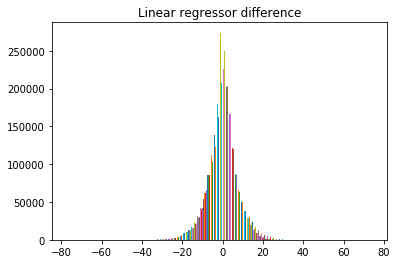

In [121]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [122]:
uif_out.reshape(-1,1).shape

(106263716, 1)

## Average Error Plots

In [146]:
real_out_avg = np.zeros([36,72])
pred_out_avg = np.zeros([36,72])

for i in range(8):
    real_out_avg += uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    pred_out_avg += uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72)
    
real_out_avg = real_out_avg/8
pred_out_avg = pred_out_avg/8

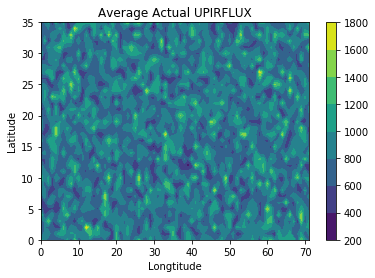

In [147]:
plt.contourf(real_out_avg)
plt.colorbar()
plt.title("Average Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

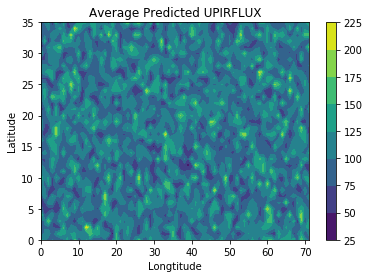

In [125]:
plt.contourf(pred_out_avg)
plt.colorbar()
plt.title("Average Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

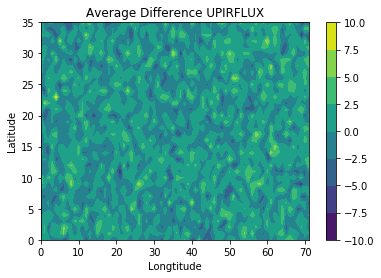

In [126]:
plt.contourf(real_out_avg - pred_out_avg)
plt.colorbar()
plt.title("Average Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

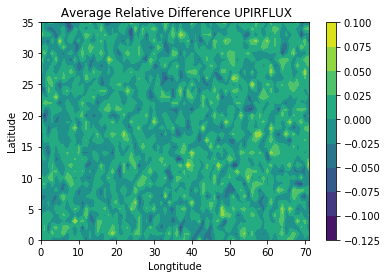

In [127]:
plt.contourf((real_out_avg - pred_out_avg)/real_out_avg)
plt.colorbar()
plt.title(" Average Relative Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Standard Deviation Error Plots

In [128]:
real_out_std = []
pred_out_std = []
diff_out_std = []


for i in range(8):
    real_out_std.append(uif_out[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))
    pred_out_std.append(uif_lin[(10+i)*36*72:(11+i)*36*72,10].reshape(36,72))

real_out_std = np.array(real_out_std)
pred_out_std = np.array(pred_out_std)
diff_out_std = real_out_std - pred_out_std

real_out_std = np.std(real_out_std, axis=0)
pred_out_std = np.std(pred_out_std, axis=0)
diff_out_std = np.std(diff_out_std, axis=0)

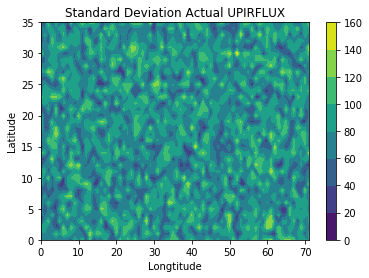

In [129]:
plt.contourf(real_out_std)
plt.colorbar()
plt.title("Standard Deviation Actual UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

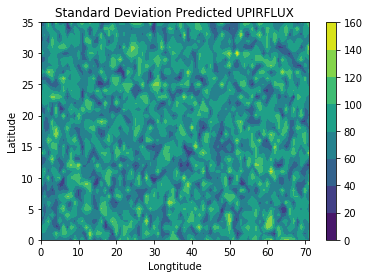

In [130]:
plt.contourf(pred_out_std)
plt.colorbar()
plt.title("Standard Deviation Predicted UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

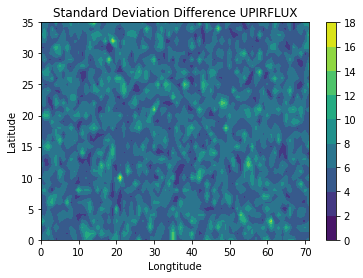

In [131]:
plt.contourf(diff_out_std)
plt.colorbar()
plt.title("Standard Deviation Difference UPIRFLUX")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [132]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [133]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [134]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-0.02294745, -0.20014132, -0.16189952, ..., -0.03825652,
        -0.04080468,  0.24981831],
       [-0.02279303, -0.1999762 , -0.16174779, ..., -0.03812016,
        -0.04064319,  0.24996148],
       [-0.02275214, -0.19993578, -0.16170405, ..., -0.03807591,
        -0.0406055 ,  0.25000615],
       ...,
       [-0.02481498, -0.22540762, -0.21509737, ..., -0.0270794 ,
        -0.10848825,  0.27559162],
       [-0.0252183 , -0.22575613, -0.21816273, ..., -0.02451116,
        -0.10791762,  0.27749352],
       [-0.02438114, -0.22369522, -0.22012068, ..., -0.02185483,
        -0.10687479,  0.27840877]])

In [135]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.34443737, 0.34458598, 0.34462831, 0.34459528, 0.34446956,
       0.34441824, 0.34424407, 0.34434099, 0.34430826, 0.34416922,
       0.34408182, 0.34404925, 0.34388804, 0.34370815, 0.34355545,
       0.34390562, 0.34405755, 0.344163  , 0.34407887, 0.34415626,
       0.34477753, 0.34596504, 0.34737458, 0.34940944, 0.34954232,
       0.34965412, 0.34858813, 0.34986631, 0.35138947, 0.35304517,
       0.35402607, 0.3576555 , 0.35801416, 0.35821293, 0.36180576,
       0.36403576, 0.36494901, 0.36515131, 0.36943554, 0.37125244,
       0.37197741, 0.37119646, 0.36907707, 0.36909062, 0.36944308,
       0.36856937, 0.36845383, 0.37094981, 0.37040152, 0.36944941,
       0.37069317, 0.37125526])

In [136]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.31526648, -0.3151198 , -0.3150773 , -0.31512644, -0.31525852,
       -0.31523369, -0.31535683, -0.31524629, -0.31536539, -0.31555387,
       -0.3155851 , -0.315495  , -0.31554411, -0.3156195 , -0.31575653,
       -0.31544682, -0.31532696, -0.31526793, -0.31548011, -0.3157856 ,
       -0.315861  , -0.31585027, -0.31634533, -0.31660848, -0.31850007,
       -0.32000627, -0.32272431, -0.32370773, -0.3253987 , -0.3280948 ,
       -0.33309682, -0.33570037, -0.34026413, -0.34536756, -0.34768616,
       -0.35071874, -0.35541342, -0.3644057 , -0.36987013, -0.37129885,
       -0.37315453, -0.3750923 , -0.37833626, -0.38011463, -0.38231387,
       -0.38492776, -0.38700669, -0.38763816, -0.39158987, -0.39469241,
       -0.39671461, -0.40023811])

In [137]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.14387459, 0.14387477, 0.14387446, 0.14387482, 0.14387466,
       0.14386903, 0.14386116, 0.14386158, 0.14386251, 0.14386087,
       0.14386271, 0.14386346, 0.14386327, 0.14386064, 0.14386649,
       0.14388622, 0.14391016, 0.1439363 , 0.14397517, 0.14404504,
       0.14416099, 0.14434204, 0.14457395, 0.1448113 , 0.14503953,
       0.14528663, 0.14558641, 0.14597253, 0.14644638, 0.14703151,
       0.14777275, 0.14863671, 0.14956022, 0.15052445, 0.15138392,
       0.15217595, 0.15322845, 0.15489492, 0.15673934, 0.15748769,
       0.15832625, 0.15888536, 0.15941946, 0.15992389, 0.16047026,
       0.16089561, 0.1614252 , 0.16213304, 0.16308672, 0.16418288,
       0.16527951, 0.16638645])

In [138]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.0055411 , -0.00538855, -0.0053458 , -0.00538339, -0.00547381,
       -0.00549407, -0.00567511, -0.00561205, -0.0056943 , -0.00584805,
       -0.00588987, -0.00584982, -0.0059592 , -0.0060754 , -0.00619428,
       -0.00585115, -0.00572004, -0.00569529, -0.00598378, -0.00622253,
       -0.00599172, -0.00540729, -0.00501359, -0.00413731, -0.00493838,
       -0.00556726, -0.00741916, -0.00731089, -0.00743263, -0.00793811,
       -0.00972007, -0.0092255 , -0.01186942, -0.01466214, -0.01432846,
       -0.01562925, -0.01702637, -0.02044059, -0.02197206, -0.02211047,
       -0.0222297 , -0.02299972, -0.02495569, -0.02528927, -0.02577115,
       -0.02728955, -0.02832736, -0.02704287, -0.02821223, -0.02891437,
       -0.02822735, -0.02881097])

In [139]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.01252131682806027


Large